# Машинное обучение в бизнесе
## Урок 1. Кейс 1. EDA по Hourly Energy Consumption и Brent

In [3]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

# Задание 1

Выберите наборы данных. которые можно интерпретировать, как временные ряды:

    а) зависимость цены на недвижимость в конкретном регионе от времени,
    б) скорость полета самолета при перелете из аэропорта А в аэропорт В,
    в) количество отказов компьютера,
    г) число обращений в поликлинику по району,
    д) координаты автобуса при движении по маршруту,
    е) координаты фигуры нарушителя в файле видеофиксации охранной системы.

**Решение**

а, б, д

# Задание 2

Прочитайте `DUQ_hourly.csv` и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

**Решение**

In [4]:
duq = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])
display(duq.info())
duq.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
DUQ_MW    119068 non-null float64
dtypes: float64(1)
memory usage: 1.8 MB


None

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0


Результат анализа типов показывает, что интервал изменения индексов начинается от `2005-12-31 01:00:00` и идет до `2018-01-02 00:00:00`. Шаг измерений по времени составляет $1$ час. Общий объем данных составляет $119068$ значений, а тип измеряемой информации при записи был определен как `float64`.

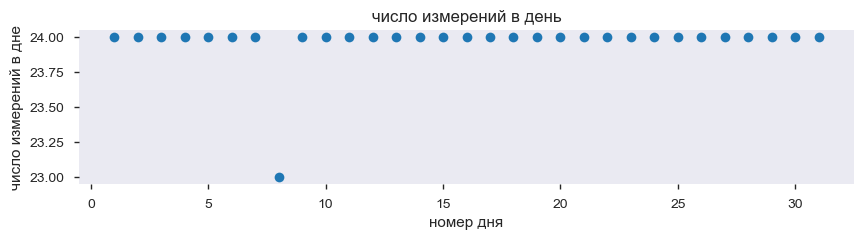

In [101]:
duq_H=duq['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

plt.figure(figsize=(10,2))
plt.plot(duq_H.value_counts().index, duq_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.grid()
plt.show()

Видим, что в момент перевода времени одно из измерений дважды приходится на один и тот же день.

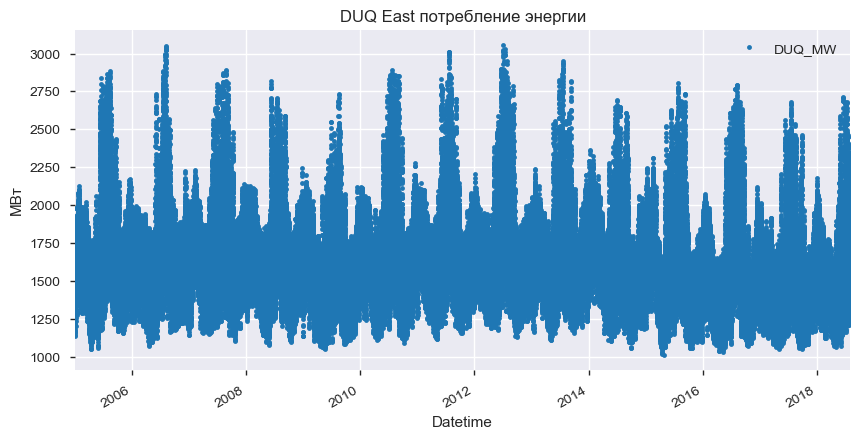

In [88]:
duq.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии')
plt.ylabel('МВт')
plt.show()

- Основные статистики показали, что пропусков нет
- Визуальный анализ показывает, что:
    - предъявленные данные имеют циклы
    - после 2014 года наблюдаем спад потребления
    
Рассмотрим годовой цикл:

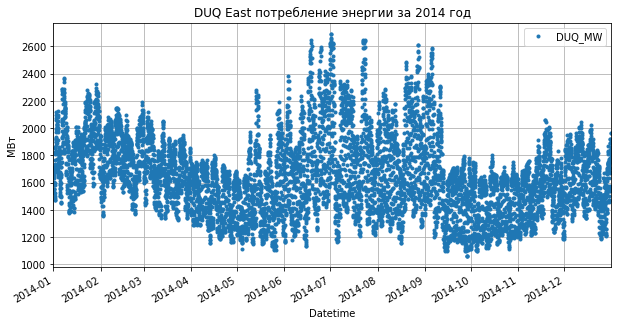

In [31]:
duq_2014 = duq.loc[lambda df: df.index.year == 2014, :].sort_index()
duq_2014.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии за 2014 год')
plt.ylabel('МВт')
plt.grid()
plt.show()

Видим, что наибольшее потребление электроэнергии приходится на период наибольшей солнечной активность, с конца мая до середины сентября, и на зимний период, с середины ноября до середины марта. Демисезон отличается наименьшей активностью электропотребителей (апрель-март и сентябрь-ноябрь).

Рассмотрим месячный цикл:

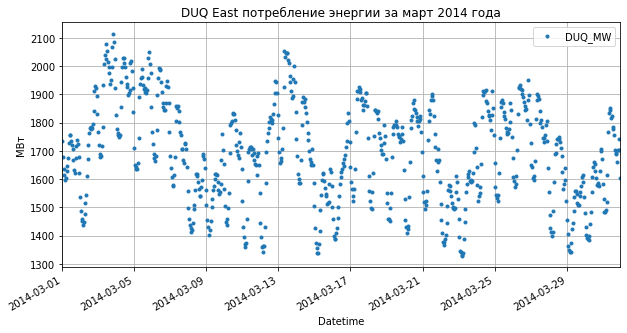

In [57]:
duq_2014_03 = duq.loc[lambda df: (df.index.year == 2014) & (df.index.month == 3), :].sort_index()
duq_2014_03.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии за март 2014 года')
plt.ylabel('МВт')
plt.grid()
plt.show()

Здесь видны недельные циклы повышенной и пониженной активности. Очевидно, что они связаны с выходными, которые приходились на $1, 2, 8, 9, 15, 16, 22, 23, 29, 30$ числа этого месяца.

Рассмотрим дневной цикл:

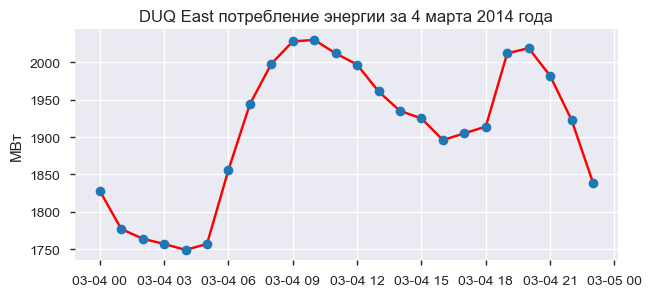

In [116]:
duq_2014_03_04 = duq.loc[lambda df: (df.index.year == 2014) & (df.index.month == 3) & (df.index.day == 4), :].sort_index()
plt.figure(figsize=(7,3))
plt.plot(duq_2014_03_04, 'r')
plt.plot(duq_2014_03_04, 'o')
plt.title('DUQ East потребление энергии за 4 марта 2014 года')
plt.ylabel('МВт')
plt.show()

Ожидаемо наблюднаем дневной цикл:
- пониженная активность в ночное время с 00:00 до 6:00
- повышенная активность в рабочие часы с 8:00 до 15:00
- средняя активность с 15:00 до 18:00
- повышенная активность в вечернее время с 19:00 до 22:00

In [62]:
## отчёт новых знаний не дал
# pandas_profiling.ProfileReport(duq)

# Задание 3

Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

**Решение**

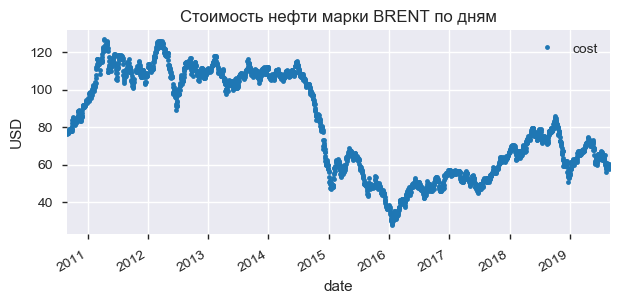

In [89]:
brent = pd.read_excel('brand.xlsx', names=['date', 'cost'], index_col=[0], parse_dates=[0]).sort_index()
brent.plot(style='.', figsize=(7, 3), title='Стоимость нефти марки BRENT по дням')
plt.ylabel('USD')
plt.show()

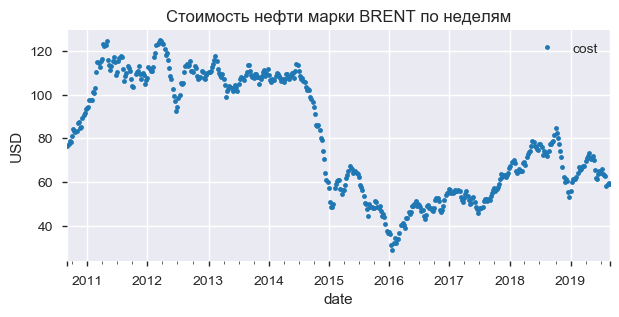

In [90]:
brent_weekly = brent.resample('W').mean().sort_index()
brent_weekly.plot(style='.', figsize=(7, 3), title='Стоимость нефти марки BRENT по неделям')
plt.ylabel('USD')
plt.show()

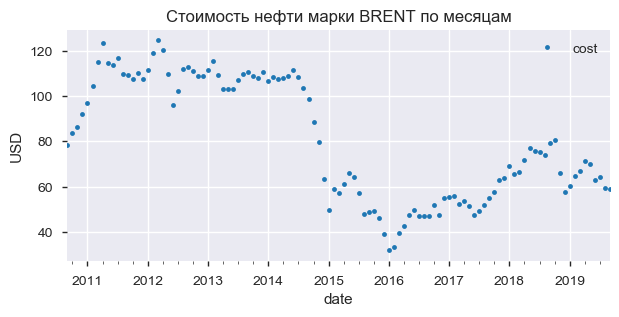

In [91]:
brent_monthly = brent.resample('M').mean().sort_index()
brent_monthly.plot(style='.', figsize=(7, 3), title='Стоимость нефти марки BRENT по месяцам')
plt.ylabel('USD')
plt.show()

# Задание 4

Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

**Решение**

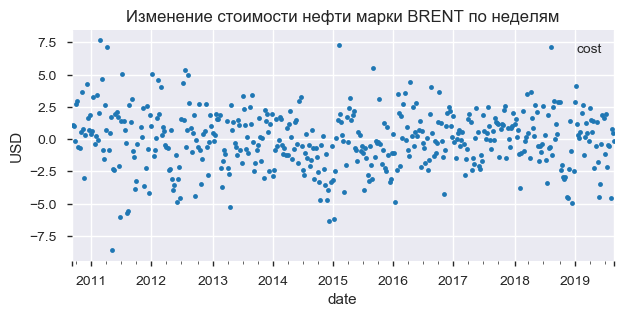

In [131]:
brent_weekly.diff().plot(style='.', figsize=(7, 3), title='Изменение стоимости нефти марки BRENT по неделям')
plt.ylabel('USD')
plt.show()

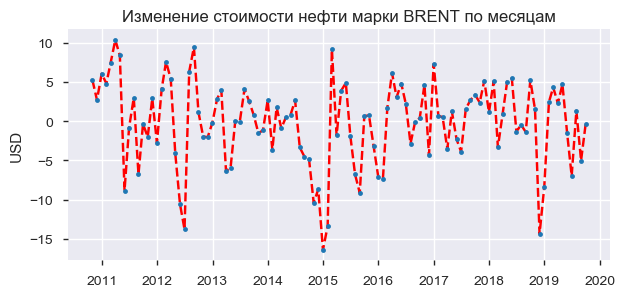

In [140]:
plt.figure(figsize=(7,3))
plt.plot(brent_monthly.diff(), '--r')
plt.plot(brent_monthly.diff(), '.')
plt.title('Изменение стоимости нефти марки BRENT по месяцам')
plt.ylabel('USD')
plt.show()

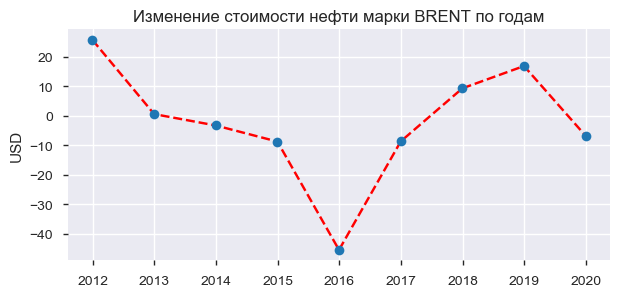

In [149]:
brent_yearly = brent.resample('Y').mean().sort_index()
plt.figure(figsize=(7,3))
plt.plot(brent_yearly.diff(), '--r')
plt.plot(brent_yearly.diff(), 'o')
plt.title('Изменение стоимости нефти марки BRENT по годам')
plt.ylabel('USD')
plt.show()

# Задание 5

Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

**Решение**

Графики сгладились, при этом тренды не изменились